In [1]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [1]:
!git clone https://github.com/MinkaiXu/CGCF-ConfGen

Cloning into 'CGCF-ConfGen'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 74 (delta 25), reused 34 (delta 1), pack-reused 0
Unpacking objects: 100% (74/74), done.


In [3]:
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.9.0+cu111.html

     |████████████████████████████████| 831.4 MB 2.5 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.9.0 which is incompatible.
Looking in links: https://data.pyg.org/whl/torch-1.9.0+cu111.html
     |████████████████████████████████| 10.4 MB 4.2 MB/s 
     |████████████████████████████████| 3.7 MB 42.8 MB/s 
     |████████████████████████████████| 1.6 MB 244 kB/s 
     |████████████████████████████████| 870 kB 192 kB/s 
     |█████████████

In [4]:
pip install torchdiffeq==0.0.1

In [5]:
pip install tqdm networkx scipy scikit-learn h5py tensorboard 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
from rdkit import Chem
from rdkit.Chem.rdchem import Mol, HybridizationType, BondType
from rdkit import RDLogger
import pickle
import torch
from tqdm.auto import tqdm
from torch_scatter import scatter
from torch_geometric.data import Data
import copy
from torch_geometric.utils import to_networkx

In [49]:
def get_data_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [50]:
def enumerate_conformers(mol):
    num_confs = mol.GetNumConformers()
    if num_confs == 1:
        yield mol
        return
    mol_templ = copy.deepcopy(mol)
    mol_templ.RemoveAllConformers()
    for conf_id in tqdm(range(num_confs), desc='Conformer'):
        conf = mol.GetConformer(conf_id)
        conf.SetId(0)
        mol_conf = copy.deepcopy(mol_templ)
        conf_id = mol_conf.AddConformer(conf)
        yield mol_conf

def rdmol_to_data(mol:Mol):
    assert mol.GetNumConformers() == 1
    N = mol.GetNumAtoms()

    pos = torch.tensor(mol.GetConformer(0).GetPositions(), dtype=torch.float)

    atomic_number = []
    aromatic = []
    sp = []
    sp2 = []
    sp3 = []
    num_hs = []
    for atom in mol.GetAtoms():
        atomic_number.append(atom.GetAtomicNum())
        aromatic.append(1 if atom.GetIsAromatic() else 0)
        hybridization = atom.GetHybridization()
        sp.append(1 if hybridization == HybridizationType.SP else 0)
        sp2.append(1 if hybridization == HybridizationType.SP2 else 0)
        sp3.append(1 if hybridization == HybridizationType.SP3 else 0)

    z = torch.tensor(atomic_number, dtype=torch.long)

    row, col, edge_type = [], [], []
    for bond in mol.GetBonds():
        start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
        row += [start, end]
        col += [end, start]
        edge_type += 2 * [BOND_TYPES[bond.GetBondType()]]
    #下面定义了BOND_TYPES


    edge_index = torch.tensor([row, col], dtype=torch.long)
    edge_type = torch.tensor(edge_type)

    perm = (edge_index[0] * N + edge_index[1]).argsort()
    edge_index = edge_index[:, perm]
    edge_type = edge_type[perm]

    row, col = edge_index
    hs = (z == 1).to(torch.float)
    num_hs = scatter(hs[row], col, dim_size=N).tolist()

    smiles = Chem.MolToSmiles(mol)

    data = Data(node_type=z, pos=pos, edge_index=edge_index, edge_type=edge_type,
                rdmol=copy.deepcopy(mol), smiles=smiles)
    data.nx = to_networkx(data, to_undirected=True)

    return data

In [51]:
pkl = '/content/drive/MyDrive/test_QM9.pkl'

In [7]:
def process_pickle(raw_path):
    dataset = []
    with open(raw_path, 'rb') as f:
        mols = pickle.load(f)
        for mol in tqdm(mols):
            for conf in enumerate_conformers(mol):
                dataset.append(rdmol_to_data(conf))
    return dataset

In [46]:
def enumerate_conformers(mol):
    num_confs = mol.GetNumConformers()
    #反正在testQM9当中num_confs=1
    if num_confs == 1:
        yield mol
        return
    mol_templ = copy.deepcopy(mol)
    mol_templ.RemoveAllConformers()
    print(num_confs)
    for conf_id in tqdm(range(num_confs), desc='Conformer'):
        conf = mol.GetConformer(conf_id)
        conf.SetId(0)
        mol_conf = copy.deepcopy(mol_templ)
        conf_id = mol_conf.AddConformer(conf)
        yield mol_conf

In [102]:
#@title chem
import random
from copy import deepcopy
import torch
from torch.nn import functional as F
from torchvision.transforms.functional import to_tensor
from torch_scatter import scatter
from torch_geometric.data import Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import to_networkx
import numpy as np
import networkx as nx
import rdkit
import rdkit.Chem.Draw
from rdkit import Chem
from rdkit.Chem import rdMolTransforms as MT
from rdkit.Chem import rdDistGeom as DG
from rdkit.Chem import rdDepictor as DP
from rdkit.Chem import PeriodicTable as PT
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem.rdchem import Mol, HybridizationType, GetPeriodicTable
from rdkit.Chem.Draw import rdMolDraw2D as MD2
from rdkit.Chem.rdmolops import RemoveHs
from rdkit.Chem.rdMolAlign import GetBestRMS


from typing import List, Tuple
import copy


BOND_TYPES = {t: i for i, t in enumerate(BT.names.values())}
BOND_NAMES = {i: t for i, t in enumerate(BT.names.keys())}


def set_conformer_positions(conf, pos):
    for i in range(pos.shape[0]):
        conf.SetAtomPosition(i, pos[i].tolist())
    return conf


def draw_mol_image(rdkit_mol, tensor=False):
    rdkit_mol.UpdatePropertyCache()
    img = rdkit.Chem.Draw.MolToImage(rdkit_mol, kekulize=False)
    if tensor:
        return to_tensor(img)
    else:
        return img


def update_data_rdmol_positions(data):
    for i in range(data.pos.size(0)):
        data.rdmol.GetConformer(0).SetAtomPosition(i, data.pos[i].tolist())
    return data


def update_data_pos_from_rdmol(data):
    new_pos = torch.FloatTensor(data.rdmol.GetConformer(0).GetPositions()).to(data.pos)
    data.pos = new_pos
    return data


def set_rdmol_positions(rdkit_mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    mol = copy.deepcopy(rdkit_mol)
    set_rdmol_positions_(mol, pos)
    return mol


def set_rdmol_positions_(mol, pos):
    """
    Args:
        rdkit_mol:  An `rdkit.Chem.rdchem.Mol` object.
        pos: (N_atoms, 3)
    """
    for i in range(pos.shape[0]):
        mol.GetConformer(0).SetAtomPosition(i, pos[i].tolist())
    return mol


def get_atom_symbol(atomic_number):
    return PT.GetElementSymbol(GetPeriodicTable(), atomic_number)


def mol_to_smiles(mol: Mol) -> str:
    return Chem.MolToSmiles(mol, allHsExplicit=True)


def remove_duplicate_mols(molecules: List[Mol]) -> List[Mol]:
    unique_tuples: List[Tuple[str, Mol]] = []

    for molecule in molecules:
        duplicate = False
        smiles = mol_to_smiles(molecule)
        for unique_smiles, _ in unique_tuples:
            if smiles == unique_smiles:
                duplicate = True
                break

        if not duplicate:
            unique_tuples.append((smiles, molecule))

    return [mol for smiles, mol in unique_tuples]


def get_atoms_in_ring(mol):
    atoms = set()
    for ring in mol.GetRingInfo().AtomRings():
        for a in ring:
            atoms.add(a)
    return atoms


def get_2D_mol(mol):
    mol = deepcopy(mol)
    DP.Compute2DCoords(mol)
    return mol


def draw_mol_svg(mol,molSize=(450,150),kekulize=False):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        DP.Compute2DCoords(mc)
    drawer = MD2.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    # return svg.replace('svg:','')
    return svg


def GetBestRMSD(probe, ref):
    # rmsd = AlignMol(probe, ref)
    probe = RemoveHs(probe)
    ref = RemoveHs(ref)
    rmsd = GetBestRMS(probe, ref)
    return rmsd, rmsd


In [104]:
#@title transforms
def get_standard_transforms(order=3, asym_name=True):
    tf = Compose([
        AddHigherOrderEdges(order=order),
        AddIsBond(),
        AddEdgeLength(),
        AddEdgeName(asymmetric=asym_name),
    ])
    return tf

import copy
import torch
from torch_sparse import spspmm, coalesce
from torch_geometric.data import Data
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.transforms import Compose



def binarize(x):
    return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))


def get_higher_order_adj_matrix(adj, order):
    """
    Args:
        adj:        (N, N)
        type_mat:   (N, N)
    """
    adj_mats = [torch.eye(adj.size(0)).long(), binarize(adj + torch.eye(adj.size(0)).long())]
    for i in range(2, order+1):
        adj_mats.append(binarize(adj_mats[i-1] @ adj_mats[1]))
    # print(adj_mats)

    order_mat = torch.zeros_like(adj)
    for i in range(1, order+1):
        order_mat += (adj_mats[i] - adj_mats[i-1]) * i

    return order_mat


class AddHigherOrderEdges(object):

    def __init__(self, order, num_types=len(BOND_TYPES)):
        super().__init__()
        self.order = order
        self.num_types = num_types

    def __call__(self, data:Data):
        N = data.num_nodes
        adj = to_dense_adj(data.edge_index).squeeze(0)
        adj_order = get_higher_order_adj_matrix(adj, self.order)  # (N, N)

        type_mat = to_dense_adj(data.edge_index, edge_attr=data.edge_type).squeeze(0)   # (N, N)
        type_highorder = torch.where(adj_order > 1, self.num_types+adj_order-1, torch.zeros_like(adj_order))
        assert (type_mat * type_highorder == 0).all()
        type_new = type_mat + type_highorder

        new_edge_index, new_edge_type = dense_to_sparse(type_new)
        _, edge_order = dense_to_sparse(adj_order)

        data.bond_edge_index = data.edge_index  # Save original edges
        data.edge_index, data.edge_type = coalesce(new_edge_index, new_edge_type.long(), N, N)
        edge_index_1, data.edge_order = coalesce(new_edge_index, edge_order.long(), N, N)
        assert (data.edge_index == edge_index_1).all()

        return data


class AddEdgeLength(object):

    def __call__(self, data:Data):
        pos = data.pos
        row, col = data.edge_index
        dist = torch.norm(pos[col] - pos[row], p=2, dim=-1).view(-1, 1)
        data.edge_length = dist
        return data


class AddEdgeName(object):

    def __init__(self, asymmetric=True):
        super().__init__()
        self.bonds = copy.deepcopy(BOND_NAMES)
        self.bonds[len(BOND_NAMES) + 1] = 'Angle'
        self.bonds[len(BOND_NAMES) + 2] = 'Dihedral'
        self.asymmetric = asymmetric

    def __call__(self, data:Data):
        data.edge_name = []
        for i in range(data.edge_index.size(1)):
            tail = data.edge_index[0, i]
            head = data.edge_index[1, i]
            if self.asymmetric and tail >= head:
                data.edge_name.append('')
                continue
            tail_name = get_atom_symbol(data.node_type[tail].item())
            head_name = get_atom_symbol(data.node_type[head].item())
            name = '%s_%s_%s_%d_%d' % (
                self.bonds[data.edge_type[i].item()] if data.edge_type[i].item() in self.bonds else 'E'+str(data.edge_type[i].item()),
                tail_name,
                head_name,
                tail,
                head,
            )
            if hasattr(data, 'edge_length'):
                name += '_%.3f' % (data.edge_length[i].item())
            data.edge_name.append(name)
        return data


class AddIsBond(object):

    def __init__(self):
        super().__init__()

    def __call__(self, data:Data):
        is_bond = []
        E = data.edge_index.size(1)
        for i in range(E):
            if data.edge_type[i].item() < len(BOND_TYPES):
                is_bond.append(True)
            else:
                is_bond.append(False)
        data.is_bond = is_bond
        return data


def get_standard_transforms(order=3, asym_name=True):
    tf = Compose([
        AddHigherOrderEdges(order=order),
        AddIsBond(),
        AddEdgeLength(),
        AddEdgeName(asymmetric=asym_name),
    ])
    return tf

In [114]:
from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader

In [107]:
from utils.dataset import *
tf = get_standard_transforms(order=args.aux_edge_order)
test_dset = MoleculeDataset(pkl, transform=tf)

In [115]:
train_iterator = get_data_iterator(DataLoader(test_dset, batch_size=args.train_batch_size, shuffle=True, drop_last=True))

In [132]:
preprocessed_data = next(train_iterator)

In [52]:
data = []
with open(pkl,'rb') as f:
    mols = pickle.load(f)
    for mol in tqdm(mols):
        for conf in enumerate_conformers(mol):
            data.append(rdmol_to_data(conf))

  0%|          | 0/17813 [00:00<?, ?it/s]

In [42]:
conf = enumerate_conformers(data[2])

In [43]:
rdmol_to_data(next(conf))

1


Data(edge_index=[2, 44], pos=[23, 3], node_type=[23], edge_type=[44], rdmol=<rdkit.Chem.rdchem.Mol object at 0x7f646dc8c5d0>, smiles='[H]OC([H])([H])[C@]([H])(OC([H])([H])C([H])([H])[H])[C@]([H])(O[H])C([H])([H])[H]', nx=Graph with 23 nodes and 22 edges)

In [8]:

from rdkit.Chem.rdchem import BondType as BT
BOND_TYPES = {t: i for i, t in enumerate(BT.names.values())}
BOND_NAMES = {i: t for i, t in enumerate(BT.names.keys())}

In [15]:
test_data = process_pickle(pkl)

  0%|          | 0/17813 [00:00<?, ?it/s]

In [17]:
test_data[1]

Data(edge_index=[2, 44], pos=[23, 3], node_type=[23], edge_type=[44], rdmol=<rdkit.Chem.rdchem.Mol object at 0x7f649124dee0>, smiles='[H]OC([H])([H])[C@]([H])(OC([H])([H])C([H])([H])[H])[C@]([H])(O[H])C([H])([H])[H]', nx=Graph with 23 nodes and 22 edges)

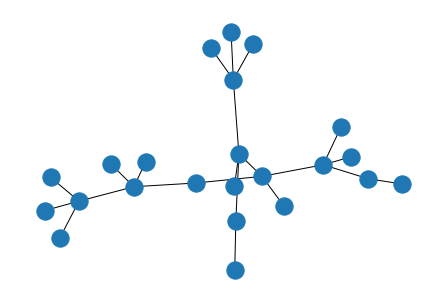

In [21]:
import networkx as nx
import matplotlib.pyplot as plt
nx.draw(test_data[1].nx)
plt.show()

In [129]:
prepocessed_data.edge_length

tensor([[0.9641],
        [1.4032],
        [2.0659],
        ...,
        [2.0947],
        [3.2088],
        [1.7845]])

In [62]:
import os
os.chdir('CGCF-ConfGen')

In [63]:
from models.edgecnf import *
from models.cnf_edge import NONLINEARITIES, LAYERS, SOLVERS

In [66]:
import os
import argparse
import random
def seed_all(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
#@title args
# Arguments
parser = argparse.ArgumentParser()
# BEGIN
# Model arguments
parser.add_argument('--activation', type=str, default='softplus')
parser.add_argument('--hidden_dim', type=int, default=64)
parser.add_argument("--num_blocks", type=int, default=1,
                    help='Number of stacked CNFs.')
parser.add_argument("--layer_type", type=str, default="concatsquash", choices=LAYERS)
parser.add_argument('--time_length', type=float, default=0.5)
parser.add_argument('--train_T', type=eval, default=True, choices=[True, False])
parser.add_argument('--use_adjoint', type=eval, default=True, choices=[True, False])
parser.add_argument('--solver', type=str, default='dopri5', choices=SOLVERS)
parser.add_argument('--atol', type=float, default=1e-5)
parser.add_argument('--rtol', type=float, default=1e-5)
parser.add_argument('--batch_norm', type=eval, default=True, choices=[True, False])
parser.add_argument('--sync_bn', type=eval, default=False, choices=[True, False])
parser.add_argument('--bn_lag', type=float, default=0)
parser.add_argument('--spectral_norm', type=eval, default=True, choices=[True, False])
parser.add_argument('--train_noise_std', type=float, default=0.1)

# Datasets and loaders
parser.add_argument('--aux_edge_order', type=int, default=3)
parser.add_argument('--train_dataset', type=str, default='./data/qm9/train.pkl')
parser.add_argument('--val_dataset', type=str, default='./data/qm9/val.pkl')
parser.add_argument('--train_batch_size', type=int, default=128)
parser.add_argument('--val_batch_size', type=int, default=256)
parser.add_argument('--num_workers', type=int, default=8)
parser.add_argument('--max_val_batch', type=int, default=5)

# Optimizer and scheduler
parser.add_argument('--lr', type=float, default=1e-3)
parser.add_argument('--weight_decay', type=float, default=0)
parser.add_argument('--sched_factor', type=float, default=0.5)
parser.add_argument('--sched_patience', type=int, default=3,
                    help='Patience steps = sched_patience * val_freq')
parser.add_argument('--sched_min_lr', type=int, default=1e-5)
parser.add_argument('--beta1', type=float, default=0.95)
parser.add_argument('--beta2', type=float, default=0.999)

# Training
parser.add_argument('--seed', type=int, default=2020)
parser.add_argument('--logging', type=eval, default=True, choices=[True, False])
parser.add_argument('--device', type=str, default='cuda')
parser.add_argument('--max_iters', type=int, default=50*1000, 
                    help='Max iterations for MLE pre-training of CNF')
parser.add_argument('--val_freq', type=int, default=300)
parser.add_argument('--inspect_freq', type=int, default=50)
parser.add_argument('--tag', type=str, default='')
parser.add_argument('--resume', type=str, default=None)
parser.add_argument('--log_root', type=str, default='./logs')
args = parser.parse_args([])
seed_all(args.seed)

In [68]:
args.batch_norm

True

In [ ]:
model = 

In [ ]:
def train(it):
    model.train()
    optimizer.zero_grad()
    if args.spectral_norm:
        spectral_norm_power_iteration(model, n_power_iterations=1)
    batch = next(train_iterator).to(args.device)
    noise = torch.randn_like(batch.edge_length) * args.train_noise_std
    loss = model.get_loss(batch, batch.edge_length + noise)
    nfe_forward = count_nfe(model)

    loss.backward()
    optimizer.step()

    nfe_total = count_nfe(model)
    nfe_backward = nfe_total - nfe_forward
    
    logger.info('[Train] Iter %04d | Loss %.6f | NFE_Forward %d | NFE_Backward %d ' % (it, loss.item(), nfe_forward, nfe_backward))
    writer.add_scalar('train/loss', loss, it)
    writer.add_scalar('train/lr', optimizer.param_groups[0]['lr'], it)
    writer.add_scalar('train/nfe_forward', nfe_forward, it)
    writer.add_scalar('train/nfe_backward', nfe_backward, it)
    writer.flush()

In [130]:
node_emb = torch.nn.Embedding(100, args.hidden_dim)      #args.hidden_dim = 64
edge_emb = torch.nn.Embedding(100, args.hidden_dim)

In [133]:
node_attr = node_emb(preprocessed_data.node_type)

In [134]:
node_attr.shape

torch.Size([2806, 64])

In [77]:
node_attr.shape

torch.Size([23, 64])

In [90]:
#@title ODE_mlp
import copy
import torch
import torch.nn as nn
from torch.nn import Parameter


class IgnoreLinear(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(IgnoreLinear, self).__init__()
        self._layer = nn.Linear(dim_in, dim_out)

    def forward(self, context, x):
        return self._layer(x)


class ConcatLinear(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(ConcatLinear, self).__init__()
        self._layer = nn.Linear(dim_in + 1 + dim_c, dim_out)

    def forward(self, context, x, c):
        if x.dim() == 3:
            context = context.unsqueeze(1).expand(-1, x.size(1), -1)
        x_context = torch.cat((x, context), dim=2)
        return self._layer(x_context)


class ConcatLinear_v2(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(ConcatLinear_v2, self).__init__()
        self._layer = nn.Linear(dim_in, dim_out)
        self._hyper_bias = nn.Linear(1 + dim_c, dim_out, bias=False)

    def forward(self, context, x):
        bias = self._hyper_bias(context)
        if x.dim() == 3:
            bias = bias.unsqueeze(1)
        return self._layer(x) + bias


class SquashLinear(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(SquashLinear, self).__init__()
        self._layer = nn.Linear(dim_in, dim_out)
        self._hyper = nn.Linear(1 + dim_c, dim_out)

    def forward(self, context, x):
        gate = torch.sigmoid(self._hyper(context))
        if x.dim() == 3:
            gate = gate.unsqueeze(1)
        return self._layer(x) * gate


class ScaleLinear(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(ScaleLinear, self).__init__()
        self._layer = nn.Linear(dim_in, dim_out)
        self._hyper = nn.Linear(1 + dim_c, dim_out)

    def forward(self, context, x):
        gate = self._hyper(context)
        if x.dim() == 3:
            gate = gate.unsqueeze(1)
        return self._layer(x) * gate


class ConcatSquashLinear(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(ConcatSquashLinear, self).__init__()
        self._layer = nn.Linear(dim_in, dim_out)
        self._hyper_bias = nn.Linear(1 + dim_c, dim_out, bias=False)
        self._hyper_gate = nn.Linear(1 + dim_c, dim_out)

    def forward(self, context, x):
        gate = torch.sigmoid(self._hyper_gate(context))
        bias = self._hyper_bias(context)
        if x.dim() == 3:
            gate = gate.unsqueeze(1)
            bias = bias.unsqueeze(1)
        ret = self._layer(x) * gate + bias
        return ret


class ConcatScaleLinear(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(ConcatScaleLinear, self).__init__()
        self._layer = nn.Linear(dim_in, dim_out)
        self._hyper_bias = nn.Linear(1 + dim_c, dim_out, bias=False)
        self._hyper_gate = nn.Linear(1 + dim_c, dim_out)

    def forward(self, context, x):
        gate = self._hyper_gate(context)
        bias = self._hyper_bias(context)
        if x.dim() == 3:
            gate = gate.unsqueeze(1)
            bias = bias.unsqueeze(1)
        ret = self._layer(x) * gate + bias
        return ret


class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
        self.beta = nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        return x * torch.sigmoid(self.beta * x)


class Lambda(nn.Module):
    def __init__(self, f):
        super(Lambda, self).__init__()
        self.f = f

    def forward(self, x):
        return self.f(x)


NONLINEARITIES = {
    "tanh": nn.Tanh(),
    "relu": nn.ReLU(),
    "softplus": nn.Softplus(),
    "elu": nn.ELU(),
    "swish": Swish(),
    "square": Lambda(lambda x: x ** 2),
    "identity": Lambda(lambda x: x),
}


class ODEmlp(nn.Module):
    """
    Helper class to make neural nets for use in continuous normalizing flows
    """

    def __init__(self, hidden_dims, input_shape, context_dim=0, layer_type="concatsquash", nonlinearity="softplus"):
        super().__init__()
        base_layer = {
            "ignore": IgnoreLinear,
            "squash": SquashLinear,
            "scale": ScaleLinear,
            "concat": ConcatLinear,
            "concat_v2": ConcatLinear_v2,
            "concatsquash": ConcatSquashLinear,
            "concatscale": ConcatScaleLinear,
        }[layer_type]

        # build models and add them
        layers = []
        activation_fns = []
        hidden_shape = input_shape

        for dim_out in (hidden_dims + (input_shape[0],)):
            layer_kwargs = {}
            layer = base_layer(hidden_shape[0], dim_out, context_dim, **layer_kwargs)
            layers.append(layer)
            activation_fns.append(NONLINEARITIES[nonlinearity])

            hidden_shape = list(copy.copy(hidden_shape))
            hidden_shape[0] = dim_out

        self.layers = nn.ModuleList(layers)
        self.activation_fns = nn.ModuleList(activation_fns[:-1])

    def forward(self, t, y, context=None):
        dx = y
        for l, layer in enumerate(self.layers):
            if context is not None:
                tc = torch.cat([t, context.view(y.size(0), -1)], dim=1)
            else:
                tc = t
            dx = layer(tc, dx)
            # if not last layer, use nonlinearity
            if l < len(self.layers) - 1:
                dx = self.activation_fns[l](dx)
        return dx


In [86]:
#@title ODEgnn_utlis
class ConcatSquashLinear(nn.Module):
    def __init__(self, dim_in, dim_out, dim_c):
        super(ConcatSquashLinear, self).__init__()
        self._layer = nn.Linear(dim_in, dim_out)
        self._hyper_bias = nn.Linear(1 + dim_c, dim_out, bias=False)
        self._hyper_gate = nn.Linear(1 + dim_c, dim_out)

    def forward(self, context, x):
        gate = torch.sigmoid(self._hyper_gate(context))
        bias = self._hyper_bias(context)
        if x.dim() == 3:
            gate = gate.unsqueeze(1)
            bias = bias.unsqueeze(1)
        ret = self._layer(x) * gate + bias
        return ret
class GINEConv(MessagePassing):

    def __init__(self, nn: Callable, eps: float = 0., train_eps: bool = False,
                 **kwargs):
        super(GINEConv, self).__init__(aggr='add', **kwargs)
        self.nn = nn
        self.initial_eps = eps
        if train_eps:
            self.eps = torch.nn.Parameter(torch.Tensor([eps]))
        else:
            self.register_buffer('eps', torch.Tensor([eps]))

    def forward(self, t, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None) -> Tensor:
        """"""
        if isinstance(x, Tensor):
            x: OptPairTensor = (x, x)

        # Node and edge feature dimensionalites need to match.
        if isinstance(edge_index, Tensor):
            assert edge_attr is not None
            assert x[0].size(-1) == edge_attr.size(-1)
        elif isinstance(edge_index, SparseTensor):
            assert x[0].size(-1) == edge_index.size(-1)

        # propagate_type: (x: OptPairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr, size=size)

        x_r = x[1]
        if x_r is not None:
            out += (1 + self.eps) * x_r

        return self.nn(t, out)

    def message(self, x_j: Tensor, edge_attr: Tensor) -> Tensor:
        return F.softplus(x_j + edge_attr)

In [88]:
#@title ODEgnn
import torch.nn.functional as F
from torch import Tensor
from typing import Callable, Union
from torch_geometric.typing import OptPairTensor, Adj, OptTensor, Size
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing
class ODEgnn(torch.nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.act = F.softplus
        self.d_fc1 = ConcatSquashLinear(1, hidden_dim, dim_c=0)
        self.d_fc2 = ConcatSquashLinear(hidden_dim, hidden_dim, dim_c=0)

        self.conv1 = GINEConv(ODEmlp((hidden_dim, ), (hidden_dim, )))
        self.conv2 = GINEConv(ODEmlp((hidden_dim, ), (hidden_dim, )))
        self.conv3 = GINEConv(ODEmlp((hidden_dim, ), (hidden_dim, )))

        self.out_fc1 = ConcatSquashLinear(2 * hidden_dim, hidden_dim, dim_c=0)
        # self.out_fc1 = ConcatSquashLinear(hidden_dim, hidden_dim, dim_c=0)
        self.out_fc2 = ConcatSquashLinear(hidden_dim, hidden_dim // 2, dim_c=0)
        self.out_fc3 = ConcatSquashLinear(hidden_dim // 2, 1, dim_c=0)

        self.edge_index = None


    def forward(self, t, x, node_attr, edge_attr):
        assert self.edge_index is not None, '`edge_index` is not prepared.'
        edge_index = self.edge_index

        d_emb = self.d_fc2(t, self.act(self.d_fc1(t, x)))   # Embedings for edge lengths `x`
        edge_attr = d_emb * edge_attr

        t_node = torch.ones_like(node_attr)[0, :1] * t.mean()
        h = node_attr
        h = self.act(self.conv1(t_node, h, edge_index, edge_attr))
        h = self.act(self.conv2(t_node, h, edge_index, edge_attr))
        h = self.conv3(t_node, h, edge_index, edge_attr)

        h_row, h_col = h[edge_index[0]], h[edge_index[1]]
        pair_feat = torch.cat([h_row*h_col, edge_attr], dim=-1)
        # pair_feat = h_row*h_col
        pair_feat = self.act(self.out_fc1(t, pair_feat))
        pair_feat = self.act(self.out_fc2(t, pair_feat))
        out = self.out_fc3(t, pair_feat)

        return out

In [91]:
diffeq=ODEgnn(hidden_dim = args.hidden_dim)

In [136]:
noise = torch.randn_like(preprocessed_data.edge_length) * args.train_noise_std
d = preprocessed_data.edge_length + noise

In [ ]:
diffeq(t,x,node_emb(preprocessed_data),edge_emb(preprocessed_data))

In [149]:
E = d.size(0)
logpx = torch.zeros(E,1).to(d)
_logpx = logpx
x = d
node_attr = node_emb(preprocessed_data.node_type)
edge_attr = edge_emb(preprocessed_data.edge_type)
states = (x, _logpx, node_attr, edge_attr)

In [150]:
y = states[0]
t = torch.ones(y.size(0), 1).to(y) * t.clone().detach().requires_grad_(True).type_as(y)

NameError: ignored

In [154]:
sqrt_end_time=torch.tensor(1)
integration_times = torch.stack(
                    [torch.tensor(0.0).to(x), sqrt_end_time * sqrt_end_time]
                ).to(x)

In [157]:
integration_times

tensor([0., 1.])

In [159]:
diffeq.edge_index = preprocessed_data.edge_index

In [162]:
diffeq(integration_times[1], x, node_attr, edge_attr)


RuntimeError: ignored